# 作业11.11

In [1]:
import matplotlib.pyplot as plt # plt 用于显示图片
import cv2 as cv # mpimg 用于读取图片
import numpy as np

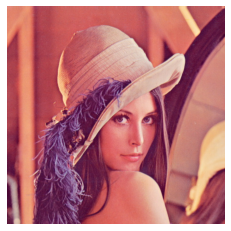

In [2]:
lena = cv.imread('lena.jpg') # 读取和代码处于同一目录下的 lena.png
lena = cv.cvtColor(lena,cv.COLOR_BGR2RGB)
def showimg(ax,img,title=None,isGray=False):
    if isGray:
        ax.imshow(img,cmap='gray')
    else:
        ax.imshow(img)
    ax.axis('off')
    if title:
        ax.set_title(title)
showimg(plt,lena)

### 1、基于opencv使用卷积操作对图像做模糊、锐化操作

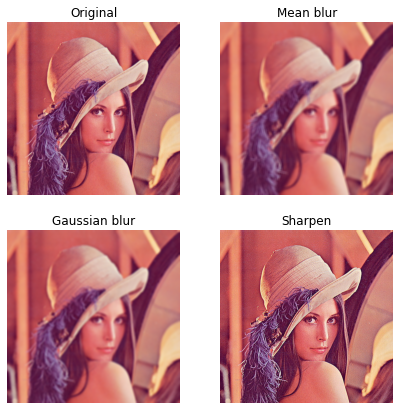

In [3]:
# tips：自定义卷积核，使用cv.filter2D对图像进行卷积操作。调整得到不同卷积核从而得到模糊或锐化的不同效果，如下图示。
# code:
kn0=np.ones(1)
kn1=np.ones((9,9))/81
kn2=cv.getGaussianKernel(9,3)
kn2=kn2@kn2.T
kn3=np.array([0,-1,0,-1,5,-1,0,-1,0]).reshape(3,3)
kernels=[kn0,kn1,kn2,kn3]
kernel_names=['Original','Mean blur','Gaussian blur','Sharpen']
fig,axs=plt.subplots(2,2,figsize=(7,7))
for name,kn,ax in zip(kernel_names,kernels,axs.flat):
    showimg(ax,cv.filter2D(lena,-1,kn),name)


### 2、使用角点检测算法对lena的灰度图进行处理并可视化结果

[-1  0  1] [[-1]
 [ 0]
 [ 1]]
[[0.01129725 0.01491455 0.01761946 0.01862602 0.01761946 0.01491455
  0.01129725]
 [0.01491455 0.01969008 0.02326108 0.02458993 0.02326108 0.01969008
  0.01491455]
 [0.01761946 0.02326108 0.02747972 0.02904957 0.02747972 0.02326108
  0.01761946]
 [0.01862602 0.02458993 0.02904957 0.03070911 0.02904957 0.02458993
  0.01862602]
 [0.01761946 0.02326108 0.02747972 0.02904957 0.02747972 0.02326108
  0.01761946]
 [0.01491455 0.01969008 0.02326108 0.02458993 0.02326108 0.01969008
  0.01491455]
 [0.01129725 0.01491455 0.01761946 0.01862602 0.01761946 0.01491455
  0.01129725]]


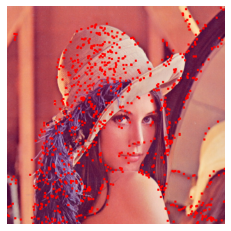

In [4]:
# tips: 角点检测算法可用Shi-Tomasi/Harris 
# codes:
lenaGray=cv.cvtColor(lena,cv.COLOR_RGB2GRAY).astype('int16')
# print(lenaGray.dtype)
dx=np.array([-1,0,1])
dy=dx.reshape(-1,1)
# dx=np.array([-1,-2,-1,0,0,0,1,2,1]).reshape(3,3)
# dy=dx.T
print(dx,dy)
lenaX=cv.filter2D(lenaGray,-1,dx)
lenaY=cv.filter2D(lenaGray,-1,dy)
knBlur=cv.getGaussianKernel(7,3)
knBlur=knBlur@knBlur.T
# knBlur=np.ones((5,5))/25
print(knBlur)
lenaX2=cv.filter2D(lenaX**2,-1,knBlur)
lenaY2=cv.filter2D(lenaY**2,-1,knBlur)
lenaXY=cv.filter2D(lenaX*lenaY,-1,knBlur)
det=lenaX2*lenaY2-lenaXY**2
K=0.04
trace=lenaX2+lenaY2
# print(det)
result=det-K*trace**2
lenaCopy=lena.copy()
for i in range(lena.shape[0]):
    for j in range(lena.shape[1]):
        if result[i][j]>1295:
            lenaCopy[i-2:i+3,j-2:j+3]=[255,0,0]
# lenaCopy[result>2000]=255
showimg(plt,lenaCopy,isGray=0)

# 3 图像分类

针对手写数字的识别任务，除了HOG特征，你还能想到使用什么其他方法作为手写数字的特征描述符进行分类吗？（需要完成另外1种或多种方法并对比效果-给出ROC曲线对比）

## 1 读取图像数据

In [5]:
# -*- coding: utf-8 -*-
#我们采用fashion-mnist，一个和mnist格式完全一致但比mnist稍难的物体识别任务数据集
#具体介绍见：https://gitee.com/mirrors/Fashion-MNIST
from sklearn import neighbors
import datetime
import cv2
import numpy as np
import struct
import matplotlib.pyplot as plt
def read_image(file_name):
    '''
    :param file_name: 文件路径
    :return:  训练或者测试数据
    如下是训练的图片的二进制格式
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000803(2051) magic number
    0004     32 bit integer  60000            number of images
    0008     32 bit integer  28               number of rows
    0012     32 bit integer  28               number of columns
    0016     unsigned byte   ??               pixel
    0017     unsigned byte   ??               pixel
    ........
    xxxx     unsigned byte   ??               pixel
    '''
    file_handle=open(file_name,"rb")  #以二进制打开文档
    file_content=file_handle.read()   #读取到缓冲区中
    head = struct.unpack_from('>IIII', file_content, 0)  # 取前4个整数，返回一个元组
    offset = struct.calcsize('>IIII')
    imgNum = head[1]  #图片数
    width = head[2]   #宽度
    height = head[3]  #高度
    bits = imgNum * width * height  # data一共有60000*28*28个像素值
    bitsString = '>' + str(bits) + 'B'  # fmt格式：'>47040000B'
    imgs = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    imgs_array=np.array(imgs).reshape((imgNum,width*height))     #最后将读取的数据reshape成 【图片数，图片像素】二维数组
    return imgs_array
def out_image(img):
    '''
    :param img: 图片像素组
    :return:
    '''
    plt.imshow(img)
    plt.axis("off")
    plt.show()
def read_label(file_name):
    '''
    :param file_name:
    :return:
    标签的格式如下：
    [offset] [type]          [value]          [description]
    0000     32 bit integer  0x00000801(2049) magic number (MSB first)
    0004     32 bit integer  60000            number of items
    0008     unsigned byte   ??               label
    0009     unsigned byte   ??               label
    ........
    xxxx     unsigned byte   ??               label
    The labels values are 0 to 9.
    '''
    file_handle = open(file_name, "rb")  # 以二进制打开文档
    file_content = file_handle.read()  # 读取到缓冲区中
    head = struct.unpack_from('>II', file_content, 0)  # 取前2个整数，返回一个元组
    offset = struct.calcsize('>II')
    labelNum = head[1]  # label数
    bitsString = '>' + str(labelNum) + 'B'  # fmt格式：'>47040000B'
    label = struct.unpack_from(bitsString, file_content, offset)  # 取data数据，返回一个元组
    return np.array(label)
def get_data():
    # 文件获取
    train_image = "./fashion_mnist/train-images-idx3-ubyte"
    train_label = "./fashion_mnist/train-labels-idx1-ubyte"
    # 读取数据
    digits = read_image(train_image)
    labels = read_label(train_label)
    return digits,labels

digits,labels=get_data()

(5000, 28, 28)
(5000,)


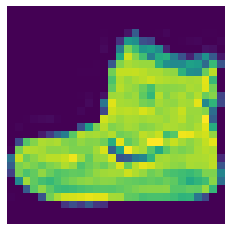

[9 0 0 3 0 2 7 2 5 5 0 9 5 5 7 9 1 0 6 4 3 1 4 8 4 3 0 2 4 4 5 3 6 6 0 8 5
 2 1 6 6 7 9 5 9 2 7 3 0 3 3 3 7 2 2 6 6 8 3 3 5 0 5 5 0 2 0 0 4 1 3 1 6 3
 1 4 4 6 1 9 1 3 5 7 9 7 1 7 9 9 9 3 2 9 3 6 4 1 1 8]


In [6]:
digits=digits.reshape(60000,28,28)
digits=digits[:5000,:,:]
labels=labels[:5000]

#数据集一共有60000张图片，为了减少同学们电脑的负担，我们使用其中5000张

print(digits.shape)
print(labels.shape)
out_image((digits[0]))
print(labels[0:100])
#分类9为“Ankle boot(踝鞋)”，对应正确

## 2 提取图像特征描述符

In [7]:
# HOG特征
winSize = (28,28)
blockSize = (14,14)
blockStride = (7,7)
cellSize = (7,7)
nbins = 9
derivAperture = 1
winSigma = 4.
histogramNormType = 0
L2HysThreshold = 2.0000000000000001e-001
gammaCorrection = 1
nlevels = 64
signedGradient = True

hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,\
            cellSize,nbins,derivAperture,winSigma,\
            histogramNormType,L2HysThreshold,gammaCorrection,\
            nlevels, signedGradient)

hog_descriptors = []
for img in digits:
    img=img.astype(np.uint8)
    hog_descriptors.append(hog.compute(img))
hog_descriptors = np.squeeze(hog_descriptors)
print(hog_descriptors.shape)

(5000, 324)


```py
# 分类结果
[[39  0  1  0  1  0  8  0  0  0]
 [ 0 48  0  0  1  0  0  0  0  0]
 [ 0  0 42  0  7  0  8  0  1  0]
 [ 2  1  0 48  1  0  1  0  0  0]
 [ 0  0  3  2 38  0  4  0  0  0]
 [ 0  0  0  0  0 44  0  0  0  0]
 [ 9  1  8  4  3  0 28  0  0  0]
 [ 0  0  0  0  0  1  0 41  0  0]
 [ 0  0  1  1  0  0  0  1 50  0]
 [ 0  0  0  0  0  1  0  2  0 49]]
***********************************
Precision:   0.854
Recall:      0.854
F1 score:    0.854
```

In [18]:
# 特征1, 分类结果存放到后一个cell中
# 对训练集中心化后进行PCA,取累计方差比例>=0.95的特征向量,使用这些特征向量对训练集和测试集降维,再使用随机森林进行分类
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
X_train, X_test, y_train, y_test = train_test_split(
        digits.reshape(5000,-1), labels, test_size=0.1, random_state=0)#先划分训练集与测试集
pca=PCA(n_components=0.95)
X_train=pca.fit_transform(X_train)
X_test=pca.transform(X_test)

```py
#分类结果
[[43  0  1  2  0  0  3  0  0  0]
 [ 0 47  1  1  0  0  0  0  0  0]
 [ 0  0 46  1  8  0  2  0  1  0]
 [ 3  0  0 48  2  0  0  0  0  0]
 [ 0  0  9  1 33  0  4  0  0  0]
 [ 0  0  0  0  0 42  0  2  0  0]
 [12  0  9  2  5  0 25  0  0  0]
 [ 0  0  0  0  0  2  0 38  0  2]
 [ 0  0  0  1  0  1  0  1 50  0]
 [ 0  0  0  0  0  1  0  3  0 48]]
***********************************
Precision:   0.84
Recall:      0.84
F1 score:    0.8399999999999999

```

In [14]:
# 特征2，分类结果存放到后一个cell中
# (其实是从网上学来的方法)
# 提取训练集的SIFT特征并进行聚类,得到K类(相当于K个词袋)),再对每张图片统计它的所有sift特征对应类别的频率直方图,再以直方图作为特征训练随机森林,进行分类
#可能是因为图片太小导致SIFT特征点很少,这一分类方法效果很差
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        digits.reshape(5000,-1), labels, test_size=0.1, random_state=0)
K=100
def get_sift(img):
    ls=cv.SIFT_create(nfeatures=50).detectAndCompute(img.reshape(28,28).astype('uint8'),None)[1]
    return ls
def get_dictionary(features):
    km=KMeans(n_clusters=K)
    km.fit(features)
    return km
def get_feature(km,sifts):
    if sifts is None:
        return np.zeros(K)
    ls=np.bincount(km.predict(sifts))
    ls.resize(K,refcheck=False)
    return list(ls)

features=[]
features_by_img=[]
for img in X_train[:]:
    arr=get_sift(img.reshape(28,28))
    features+=[] if arr is None else [x for x in arr]
    features_by_img.append(arr)
print('qwq')
km=get_dictionary(np.array(features))
print('pwp')
new_features=[]
for feature in features_by_img:
    new_features.append(get_feature(km,feature))
X_train=np.array(new_features)
new_features=[]
for img in X_test:
    new_features.append(get_feature(km,get_sift(img)))
X_test=np.array(new_features,dtype='int8')
print(X_train.shape,X_test.shape)
# print(X_test)

qwq
pwp
(4500, 100) (500, 100)


```py

# 分类结果
[[26  8  0  6  1  2  2  1  3  0]
 [ 1 40  0  4  1  1  1  0  1  0]
 [ 0  4 20  3 12  2 13  1  3  0]
 [ 5  9  1 24  3  2  3  5  1  0]
 [ 0  2 14  2 21  0  5  0  2  1]
 [ 2  3  1  1  1 26  2  5  1  2]
 [ 5  7  8  8 10  3  8  2  2  0]
 [ 0  4  1  2  0  2  1 27  0  5]
 [ 1  3  2  4  5  0  1  2 34  1]
 [ 3  2  1  0  0  0  2  4  3 37]]
***********************************
Precision:   0.526
Recall:      0.526
F1 score:    0.526

```

In [29]:
#特征3,直接把图像拍扁作为特征,用随机森林分类....然而实际效果非常好(???)
flatten_descriptors=digits.reshape(5000,-1)

```py

# 分类结果
[[42  0  0  1  0  0  6  0  0  0]
 [ 0 48  0  1  0  0  0  0  0  0]
 [ 0  0 45  0  9  0  3  0  1  0]
 [ 1  0  0 51  0  0  1  0  0  0]
 [ 0  0  2  1 39  0  5  0  0  0]
 [ 0  0  0  0  0 44  0  0  0  0]
 [ 6  0 10  4  5  0 27  0  1  0]
 [ 0  0  0  0  0  3  0 35  0  4]
 [ 0  0  0  0  0  1  1  0 51  0]
 [ 0  0  0  0  0  2  0  2  0 48]]
***********************************
Precision:   0.86
Recall:      0.86
F1 score:    0.8599999999999999

```

## 3 分类

In [30]:
# 需将特征改为需要使用的特征
features_descriptors = flatten_descriptors

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        features_descriptors, labels, test_size=0.1, random_state=0)

In [32]:
# 若分类效果差，可选用其他分类方法
print(X_train.shape)
# from sklearn.svm import SVC
# clf = SVC()
# clf.fit(X_train, y_train) 
# y_pred = clf.predict(X_test)

# from sklearn.neighbors import KNeighborsClassifier
# clf=KNeighborsClassifier(n_neighbors=10,n_jobs=-1)
# clf.fit(X_train,y_train)
# y_pred=clf.predict(X_test)

from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_jobs=-1)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
y_pred_proba=clf.predict_proba(X_test)
# print(y_pred_proba)

(4500, 784)


## 4 分类结果

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

print(confusion_matrix(y_test, y_pred))
print('*' * 35)
print("Precision:  ", precision_score(y_test, y_pred, average='micro'))
print("Recall:     ", recall_score(y_test, y_pred, average='micro'))
print("F1 score:   ", f1_score(y_test, y_pred, average='micro'))

[[44  0  1  2  0  0  2  0  0  0]
 [ 0 48  0  1  0  0  0  0  0  0]
 [ 0  0 44  0 11  0  2  0  1  0]
 [ 1  1  1 50  0  0  0  0  0  0]
 [ 0  0  4  1 40  0  2  0  0  0]
 [ 0  0  0  0  0 44  0  0  0  0]
 [ 6  0 11  4  4  0 28  0  0  0]
 [ 0  0  0  0  0  2  0 37  0  3]
 [ 0  0  0  0  0  1  1  0 51  0]
 [ 0  0  0  0  0  2  0  3  0 47]]
***********************************
Precision:   0.866
Recall:      0.866
F1 score:    0.866


In [12]:
#分类结果对比
#使用micro-average绘制ROC曲线
from sklearn.metrics import roc_curve
def get_curve(test,pred):
    test_mat=np.zeros_like(pred)
    test_mat[range(len(test)),test]=1
    # print(test_mat)
    return roc_curve(test_mat.flat,pred.flat)

In [13]:
fpr_hog,tpr_hog,_=get_curve(y_test,y_pred_proba)

In [17]:
fpr_sift,tpr_sift,_=get_curve(y_test,y_pred_proba)

In [21]:
fpr_pca,tpr_pca,_=get_curve(y_test,y_pred_proba)

In [34]:
fpr_flatten,tpr_flatten,_=get_curve(y_test,y_pred_proba)

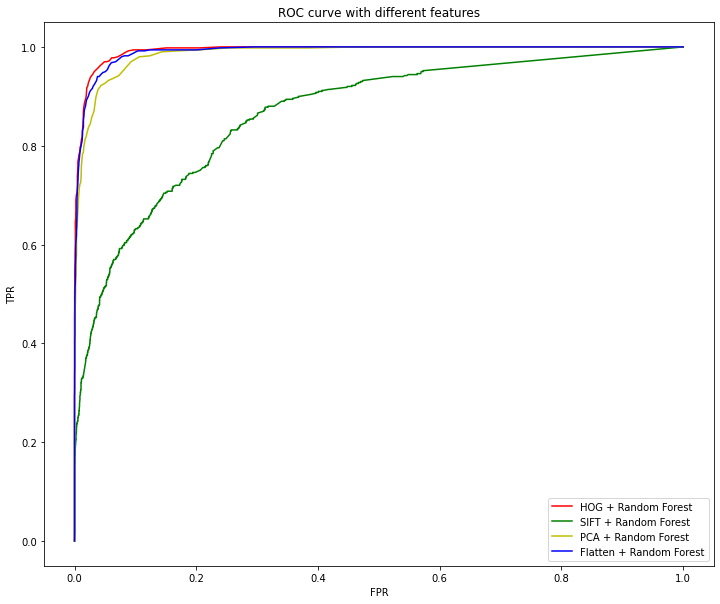

In [35]:
plt.figure(figsize=(12,10))
plt.plot(fpr_hog,tpr_hog,'r',label='HOG + Random Forest')
plt.plot(fpr_sift,tpr_sift,'g',label='SIFT + Random Forest')
plt.plot(fpr_pca,tpr_pca,'y',label='PCA + Random Forest')
plt.plot(fpr_flatten,tpr_flatten,'b',label='Flatten + Random Forest')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve with different features')
plt.legend()
plt.show()